In [89]:
import quantiacsToolbox
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

In [155]:
#TS code II
class mystrategy(object):
    def myTradingSystem(self, DATE, OPEN, HIGH, LOW, CLOSE, VOL, OI, P, R, RINFO, exposure, equity, settings):
        #function def -> last ke 20, 60 din lega
        def bollingerbands(a, n=20, m=60):
            sma20 = np.nansum(a[-20:])/20
            sma60 = np.nansum(a[-60:])/60 
            std5 = np.std(a[-5:],ddof=1)
            std20 = np.std(a[-20:],ddof=1)
            std60 = np.std(a[-60:],ddof=1)
            return sma20, sma60, std5, std20, std60
        
        def predict(close, lookback):
            ##training
                 #X = np.concatenate([CLOSE[i:i + gap] for i in range(lookback - gap)], axis=1).T 
            X_close = np.concatenate([close[i+55:i+60] for i in range(0, lookback-60)], axis=1).T
            #print('Shape:', X_close.shape)
            [n,m] = X_close.shape
            X_others = np.zeros((n,5), dtype=np.float)
            #print(X_others.shape)
            for j in range(lookback-60):
                sma20, sma40, std5, std20, std60 = bollingerbands(close[j:j+60]) 
                #print(sma20, sma40, std)
                X_others[j,:] = [sma20, sma40, std5, std20, std60]
            #print(X_others.shape)
            #print(X_close.shape)
            X = np.append(X_close, X_others, axis=1)
            y = close[60:]                                 #y = CLOSE[60:]
            #print(X.shape, y.shape)
            reg = linear_model.LinearRegression()
            try:
                reg.fit(X,y)
                ###predicting
                x_others = np.zeros((5,1)).T
                x_close = np.zeros((5,1)).T
                sma20, sma40, std5, std20, std60 = bollingerbands(close[:])
                x_others[:] = np.array([sma20, sma40, std5, std20, std60])
                x_close = close[-5:].T
                #print(x_close.shape, x_others.shape)
                x = np.append(x_close, x_others, axis=1)
                #print(x.shape)
                pred_pr = reg.predict(x)
                last_pr = close[-1]
                if pred_pr >= last_pr*(1.05):
                    position = 1.00
                elif pred_pr <= last_pr*(0.95):
                    position = -1.00
                else:
                    position = 0.00
            except ValueError:
                position = 0.00
                
            return position
        
        # Get parameters from setting
        nMarkets = len(settings['markets'])
        lookback = settings['lookback']
        dimension = settings['dimension']
        threshold = settings['threshold']
        
        pos = np.zeros((1,nMarkets), dtype=np.float)
        
        poly = PolynomialFeatures(degree=dimension)
        reg = linear_model.LinearRegression()
        #x_others = np.zeros((5,1)).T
        #x_close = np.zeros((5,1)).T
        
        for market in range(nMarkets):
            pos[0, market] = predict(CLOSE[:, market].reshape(-1,1), lookback)
    
        return pos, settings
                
                         
    def mySettings(self):
        #""" Define your trading system settings here """

        settings = {}

        # Futures Contracts
        settings['markets'] = ['CASH', 'F_AD', 'F_BO', 'F_BP', 'F_C', 'F_CC', 'F_CD']
        #settings['beginInSample'] = '19900101'
        #settings['endInSample'] = '20170522'
        settings['lookback'] = 100
        settings['budget'] = 10 ** 6
        settings['slippage'] = 0.05
        settings['dimension'] = 5
        settings['threshold'] = 0.3

        return settings   

Loading Data...
Done!
Evaluating Trading System <class '__main__.mystrategy'>


/home/anshul/anaconda3/lib/python3.6/site-packages/quantiacsToolbox/quantiacsToolbox.py:881: RuntimeWarning: invalid value encountered in true_divide
  position = position / np.sum(abs(position))


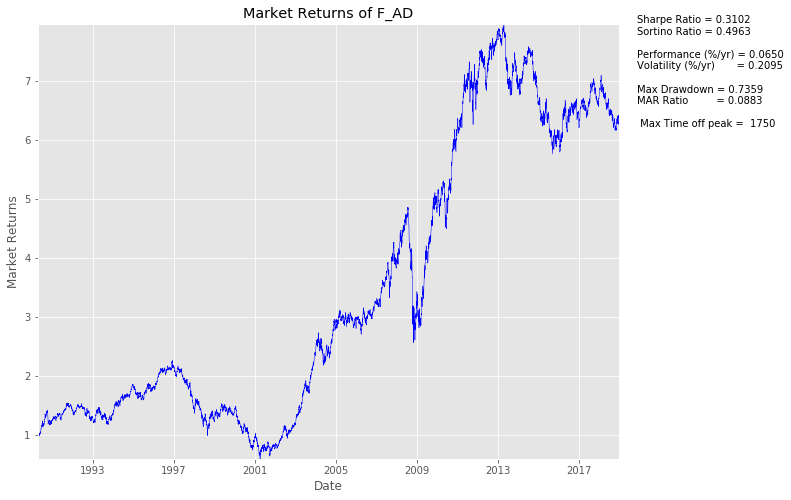

In [156]:
result = quantiacsToolbox.runts(mystrategy)